# FBN Generator Validation

**Description**

An algorithm for generating fractional Brownian noise (FBN) with a given Hurst exponent.

In [1]:
import numpy as np
import math
import scipy.stats as stats
from tqdm import tqdm
from itertools import islice

from StatTools.analysis.dpcca import dpcca
from StatTools.generators.lbfbm_generator import LBFBmGenerator, normalize
from StatTools.generators.base_filter import FilteredArray

In [2]:
config = {
    "overlap_step": 1,
    "hurst_min": 0.1,
    "hurst_max": 2.0,
    "base_min": 1.05,
    "base_max": 2.0,
    "rate": 12
}

In [3]:
valdata = {
    "h_list": [i * 0.01 for i in range(int(config["hurst_min"] * 100), 
                                       int(config["hurst_max"] * 100) + 1,
                                       10)],
    "base_list": [i * 0.01 for i in range(int(config["base_min"] * 100), 
                                       int(config["base_max"] * 100) + 1,
                                       5)],
}

In [4]:
def get_test_h(
    base: float,
    h: float,
    scales: np.ndarray,
    step: int,
    target_len: int,
) -> float:
    """
    Calculates the Hurst exponent for the generated trajectory.

    Parameters:
        base: The base of the number system for bins
        h: The specified Hurst exponent
        scales: Scales for analysis: points where fluctuation function F(s) is calculated.
        step: The step for analysis (share of scales)

    Returns:
        Calculated Hurst exponent (h_gen)
    """
    generator = LBFBmGenerator(h, base, length=target_len)
    trj = list(generator)
    filter_len = generator.filter_len

    signal_z = normalize(np.array(trj[::-1]))
    _, _, f_z, s_z = dpcca(signal_z, 2, step, scales, processes=1, n_integral=0)
    f_z = np.sqrt(f_z)
    f_z /= f_z[0]
    res = stats.linregress(np.log(s_z), np.log(f_z)).slope
    return res, filter_len

In [5]:
def validate_generator(
    H_list: list, base_list: list, scales: np.ndarray, step: float, target_len: int
):
    data = {"base": [], "h": [], "h_test": [], "filter_len": []}
    for base in tqdm(base_list):
        for h in H_list:
            h_test, filter_len = get_test_h(base, h, scales, step, target_len)
            data["base"].append(round(base, 2))
            data["h"].append(round(h, 2))
            data["h_test"].append(h_test)
            data["filter_len"].append(filter_len)
    return data

In [6]:
data = validate_generator(
    valdata["h_list"],
    valdata["base_list"],
    np.array([2**i for i in range(3, config["rate"] - 3)]),
    config["overlap_step"],
    2 ** config["rate"],
)

100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


## Plot results

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Heatmap
To validate the different bases of the filter optimization algorithm, we will build a heatmap for the received data. Where the specified h is located on the y-axis, and the x-axis is the base specified when creating the generator. In the center is the error modulus value between the expected h and the one obtained from the generated trajectory.

For clarity, the dimensions of the optimized filter are plotted under the heatmap (note that the filter before optimization = the length of the desired trajectory, that is, 4000 in this case).

In [8]:
df = pd.DataFrame(data)
df["error"] = (df["h_test"] - df["h"]).abs()
pivot_table = df.pivot_table(index="h", columns="base", values="error", aggfunc="mean")

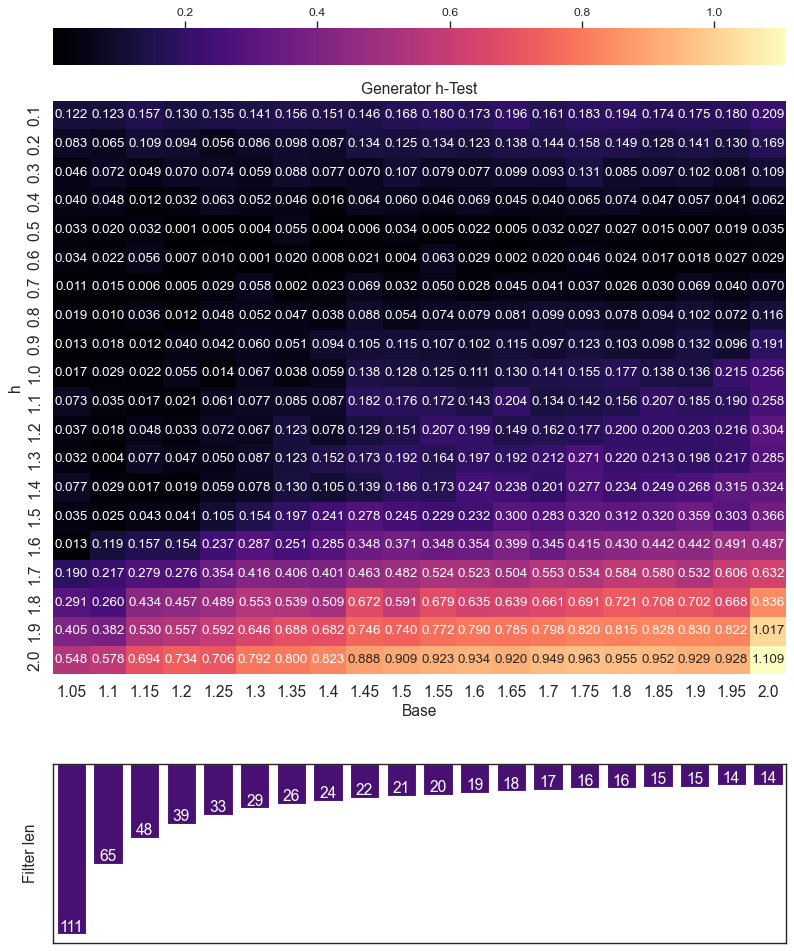

In [9]:
fontsize = 14
sns.set_theme(style="white")
fig = plt.figure(figsize=(16, 16), dpi=80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], yticklabels=[])

sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f",
    cmap="magma",
    ax=ax_main,
    cbar_kws=dict(use_gridspec=False, location="top"),
)
ax_bottom.set(title="", ylabel="Filter len", xlabel="")
sns.barplot(data=data, x="base", y="filter_len", ax=ax_bottom, color="indigo")
ax_bottom.bar_label(ax_bottom.containers[0], fontsize=fontsize, color="white")
ax_bottom.set_xticklabels([])
ax_bottom.set_xlabel("")
ax_bottom.invert_yaxis()

ax_main.set(title="Generator h-Test", ylabel="h", xlabel="Base")
ax_main.title.set_fontsize(fontsize)
for item in (
    [ax_main.xaxis.label, ax_main.yaxis.label]
    + ax_main.get_xticklabels()
    + ax_main.get_yticklabels()
):
    item.set_fontsize(fontsize)
for item in (
    [ax_bottom.xaxis.label, ax_bottom.yaxis.label]
    + ax_bottom.get_xticklabels()
    + ax_bottom.get_yticklabels()
):
    item.set_fontsize(fontsize)
plt.show()

### MSE and MAE graphs 
They are also constructed to determine valid bases.

In [10]:
results = (
    df.groupby("base")
    .apply(
        lambda x: pd.Series(
            {
                "MSE": mean_squared_error(x["h"], x["h_test"]),
                "MAE": mean_absolute_error(x["h"], x["h_test"]),
            }
        ),
        include_groups=False,
    )
    .reset_index()
)

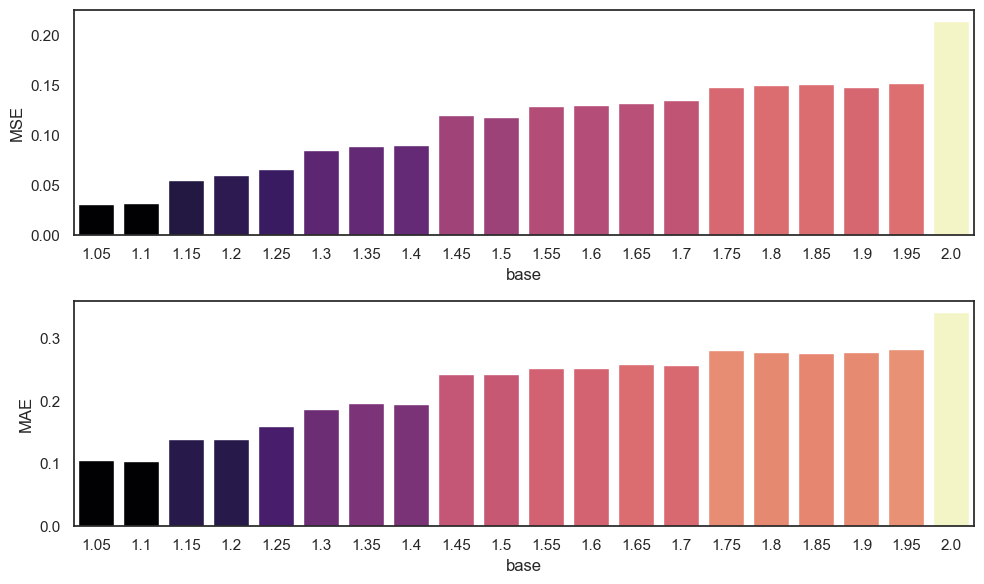

In [11]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
sns.barplot(x="base", y="MSE", hue="MSE", legend=False, data=results, palette="magma")
plt.xlabel("base")
plt.ylabel("MSE")

plt.subplot(2, 1, 2)
sns.barplot(x="base", y="MAE", hue="MAE", legend=False, data=results, palette="magma")
plt.xlabel("base")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

### Plot FF

In [12]:
tab_colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
]

In [13]:
config = {
    "overlap_step": 1,
    "hurst_min": 0.1,
    "hurst_max": 2.0,
    "base_min": 1.05,
    "base_max": 2.0,
    "rate": 13
}

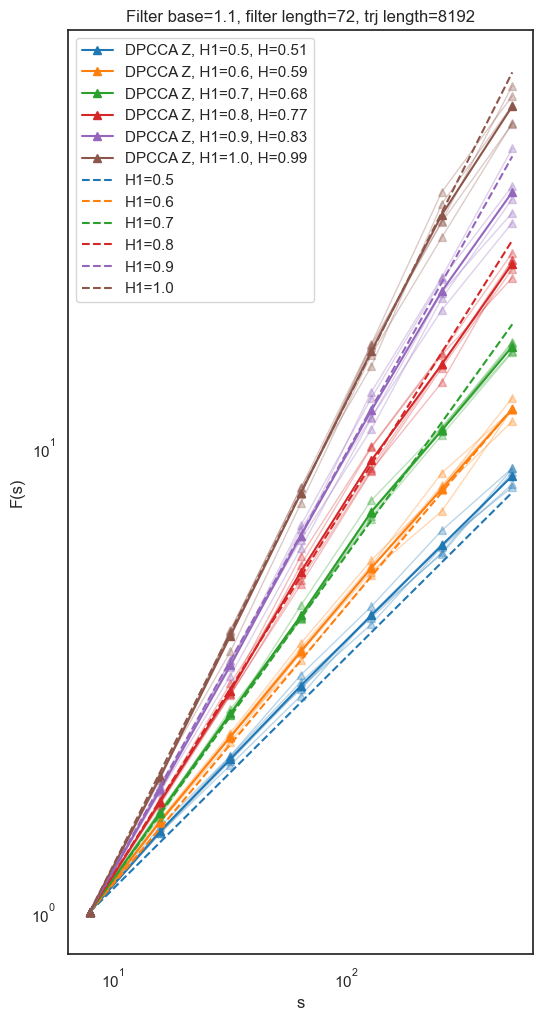

In [14]:
H = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.figure(figsize=(6, 12))
base = 1.1
scales = np.array([2**i for i in range(3, config["rate"] - 3)])
for i, h in enumerate(H):
    f_z_list = []
    for _ in range(5):
        generator = LBFBmGenerator(h, base, length=2 ** config["rate"])
        trj = []
        for value in islice(generator, 2 ** config["rate"]):
            trj.append(value)

        signal_z = normalize(np.array(trj[::-1]))
        _, _, f_z, s_z = dpcca(
            signal_z, 2, config["overlap_step"], scales, processes=1, n_integral=0
        )
        f_z = np.sqrt(f_z)
        f_z /= f_z[0]
        res = stats.linregress(np.log(s_z), np.log(f_z)).slope
        f_z_list.append(f_z)
        plt.loglog(
            scales,
            f_z,
            "^-",
            c=tab_colors[i],
            alpha=0.3,
            linewidth=1,
        )
    plt.loglog(
        scales,
        np.mean(f_z_list, axis=0),
        "^-",
        label=f"DPCCA Z, H1={h}, H={round(res, 2)}",
        c=tab_colors[i],
    )

for i, H1 in enumerate(H):
    plt.loglog(
        scales,
        [s**H1 / scales[0] ** H1 for s in scales],
        tab_colors[i],
        label=f"H1={H1}",
        linestyle="--",
    )
plt.title(
    f"Filter base={base}, filter length={generator.filter_len}, trj length={2**config['rate']}"
)
plt.xlabel("s")
plt.ylabel("F(s)")
plt.legend()
plt.show()

## Profiling and Timing

In [15]:
h = 0.8
length = 2 **12

In [16]:
base = 1.1
generator = LBFBmGenerator(h, base, length=length)
%timeit -n 1000 -r 1 generator.__next__()

72.7 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)


In [17]:
def create_trajectory_LBFBmGenerator(h, base, length):
    generator = LBFBmGenerator(h, base, length=length)

    trj = []
    for value in islice(generator, length):
        trj.append(value)
    return trj

def create_trajectory_FilteredArray(h, length):
    generator = FilteredArray(h, length)

    trj = []
    for value in islice(generator, length):
        trj.append(value)
    return trj

In [18]:
base = 1.15
length = 2 **12
h = 0.8

In [20]:
for length in [2**12, 2**14, 2**16]:
    %timeit -n 5 create_trajectory_LBFBmGenerator(h, base, length)

202 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
972 ms ± 7.12 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
4.55 s ± 37.6 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [21]:
for length in [2**12, 2**14, 2**16]:
    %timeit -n 5 create_trajectory_FilteredArray(h, length)

1.84 ms ± 701 μs per loop (mean ± std. dev. of 7 runs, 5 loops each)
5.04 ms ± 105 μs per loop (mean ± std. dev. of 7 runs, 5 loops each)
20.8 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
